# Kalman Filter for LUNA Modelling

## Explanation

In order to predict drop out, we can start by estimating an underlying latent variable ("intent to drop out"). My Understanding is, that this is mostly measured by the PANNP (etc) items. We can map these items into a latent space using the loadings found via CFA. With these, we can then measure and predict the "intent to drop out".

### Assumption: The loadings do infact measure this latent factor! We need to check this!

## Usage

See below for an example. The model at this point only runs on a per-person basis. 

## Next steps

1. Get this running on real data
2. Deploy
3. We can probably extend this into a type of multi-level model, by passing all students in a class, with a given covariance structure.


## Disclaimer: 
<span style="color:red">

There are likely some pretty big errors in here that lead to good performance. Either some mega reduction of noise (or lack of), or something else... I'm not sure... but im suspicious that this works so well!</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (15, 7)

In [2]:
def kalman_filter(X, A, H, Q, R, initial_state, initial_covariance):
    """
    Kalman filter implementation for estimating a single latent state.

    Parameters:
    - X: Input matrix of observations (shape: (3, T))
    - A: State transition matrix (shape: (1, 1))
    - H: Observation matrix (shape: (1, 3))
    - Q: Process noise covariance matrix (shape: (1, 1))
    - R: Observation noise covariance matrix (shape: (3, 3))
    - initial_state: Initial state estimate (shape: (1, 1))
    - initial_covariance: Initial state covariance matrix (shape: (1, 1))

    Returns:
    - state_estimates: Array of estimated latent states (shape: (1, T))
    - state_covariances: Array of state covariance matrices (shape: (1, 1, T))
    """

    T = X.shape[1]

    state_estimates = np.zeros((1, T))
    state_covariances = np.zeros((1, 1, T))

    # Initialization
    state_estimate = initial_state
    state_covariance = initial_covariance

    for t in range(T):
        # Prediction Step
        state_estimate_pred = A @ state_estimate
        state_covariance_pred = A @ state_covariance @ A.T + Q

        # Update Step
        observation_residual = X[:, t] - state_estimate_pred @ H
        observation_covariance = H.T @ state_covariance_pred @ H + R
        kalman_gain = state_covariance_pred @ H @ np.linalg.inv(observation_covariance)
        state_estimate = state_estimate_pred + kalman_gain @ observation_residual.T
        state_covariance = (np.eye(1) - kalman_gain @ H.T) @ state_covariance_pred

        # Save results
        state_estimates[:, t] = state_estimate.flatten()
        state_covariances[:, :, t] = state_covariance

    return state_estimates.reshape(-1), state_covariances

## Example Usage

We define the number of Time points (T) we want to simulate (this is not at all important)

Then, we define the different matrices required:

    A: State Transition matrix (read more about this)
    H: The observation matrix (factor loadings)
    Q: Variance of the latent factor (need to define this based on the data - unsure how)
    R: Observation noise - covariance (need to learn this somewhere)
    initial_state: starting point of the state. We can assume 0, (no intent to drop out), but we can also assume this to be slightly above 0 (dependent on scale)
    initial_cov: covariance of the latent factor

From here, we simulate some data:

    true_state: some random walk (also works without random work, i.e. random noise)
    noise: some random noise to avoid measurement error free observations (latent * loading + noise = observed)
    X: combination of the above, and final data

Then, we just call the function and verify the results by plotting

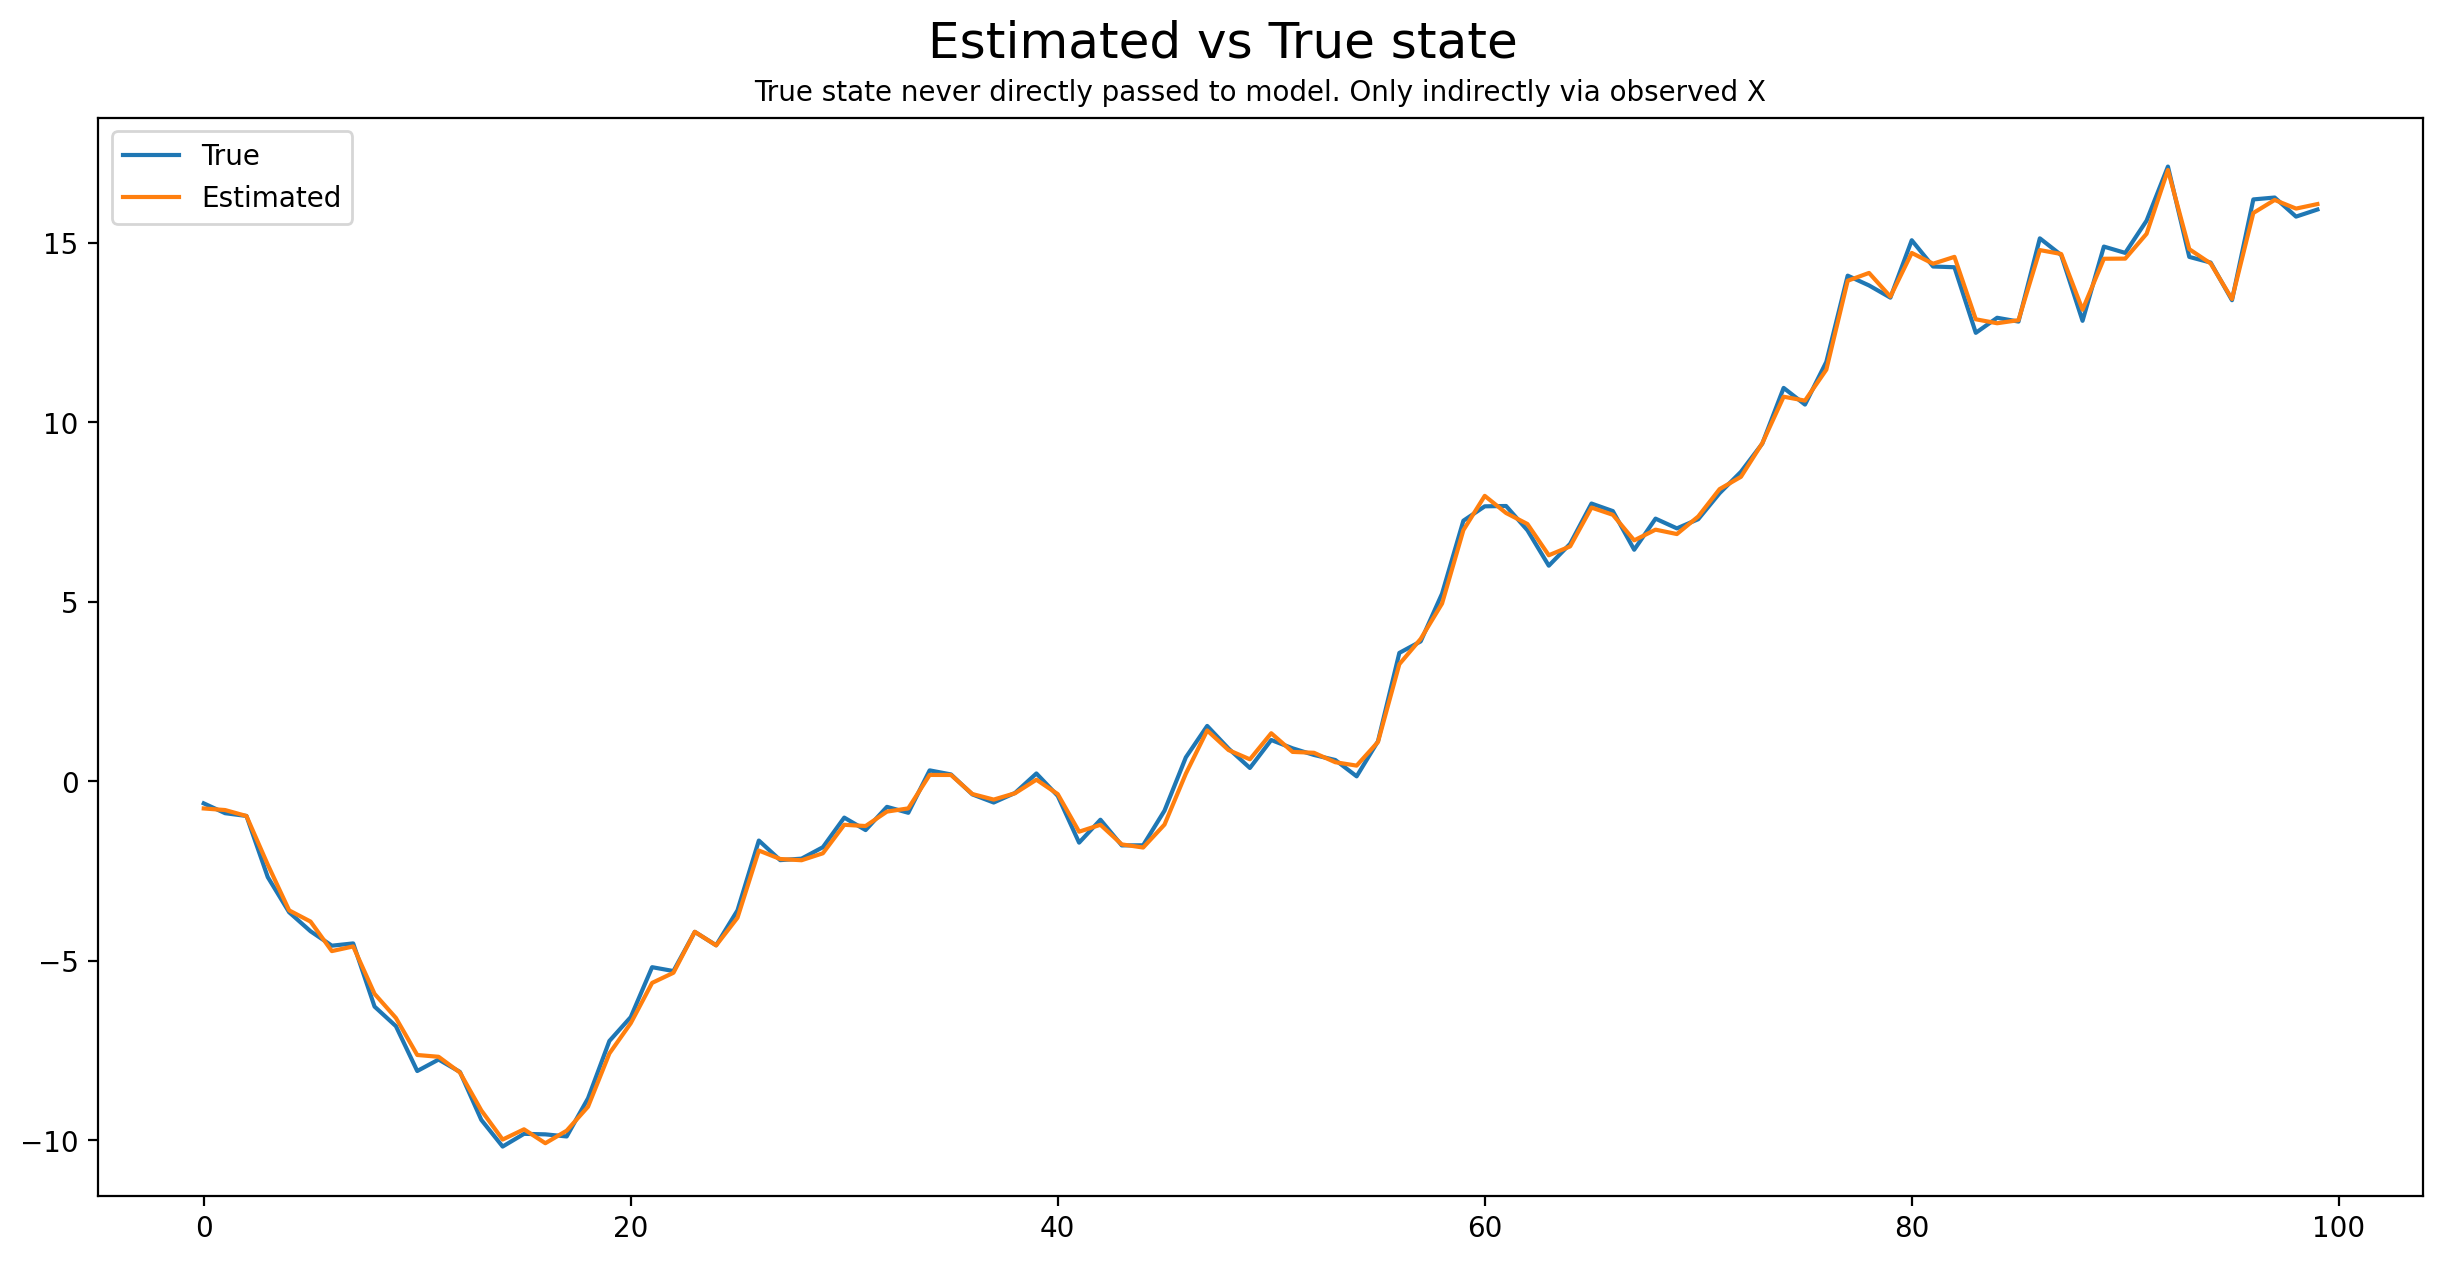

In [3]:
# Example Usage
T = 100  # Number of time points


# Define Kalman filter parameters
A = np.array([[1]])  # State transition matrix
H = np.array([[1, 3, -2]])  # Observation matrix
Q = np.array([[1]])  # Process noise covariance
R = np.array([[30, 0.1, -15],
              [0.1  ,   1, 0.2],
              [-15  , 0.2, 20]])  # Observation noise covariance
initial_state = np.array([[0]])  # Initial state estimate
initial_covariance = np.array([[1]])  # Initial state covariance

true_state = np.cumsum(np.random.normal(loc=0.01, scale=1, size=T)).reshape(1,-1)
true_state = simulate_ar3(T, [0.7,0.2,0.1]).reshape(1,-1)
noise = np.random.multivariate_normal(mean=[0,0,0], cov = R, size=T).T
X = (true_state.T @ H).T + noise

# Run Kalman filter
state_estimates, state_covariances = kalman_filter(X, A, H, Q, R, initial_state, initial_covariance)

# Print the final estimated state
plt.plot(true_state.flatten(), label="True");
plt.plot(state_estimates, label="Estimated");
plt.suptitle("Estimated vs True state", y=.95, fontsize=18)
plt.title("True state never directly passed to model. Only indirectly via observed X", fontsize=10)
plt.legend();

### KF on real Data

In [56]:
#data preperation
tx = pd.read_csv("tx_long.csv")
pivoted = tx.pivot(index='studentID',columns='meas',values=['PANN01_state','PANN05_state','PANN09_state'])
pivoted_no_na = pivoted.fillna(2)
PANN01_state = pivoted_no_na['PANN01_state'].T
PANN05_state = pivoted_no_na['PANN05_state'].T
PANN09_state = pivoted_no_na['PANN09_state'].T
Y1 = PANN01_state.to_numpy()
Y2 = PANN05_state.to_numpy()
Y3 = PANN09_state.to_numpy()
Y = np.stack((Y1,Y2,Y3),axis=2) #axis=0 would lead to (3, 50, 117)
Y = np.transpose(Y,(1,2,0))
Y.shape


(117, 3, 50)

In [75]:
prediction_estimates = np.zeros((117,50))
prediction_covariances = np.zeros((117,50))

for individual in range(1,len(Y)):
    for time in range(1,len(Y[1][1])):
        prediction_estimates[individual,time], prediction_covariances[individual,time] = kalman_filter(Y[individual,:,time].reshape(3,1), A, H, Q, R, initial_state, initial_covariance)





/var/folders/pt/6yry233n1ds827z05bs1d95w0000gn/T/ipykernel_74758/2832730843.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction_estimates[individual,time], prediction_covariances[individual,time] = kalman_filter(Y[individual,:,time].reshape(3,1), A, H, Q, R, initial_state, initial_covariance)


In [77]:
prediction_estimates

(117, 50)

## Smoother (still work in progress)

In [622]:
T = 10
inity = np.array([4,5])
y = np.zeros(T)

y[:len(inity)] = inity
K = np.array([0.4,0.3])

for t in range(T-len(inity)):
    t = t + len(inity)
    idx = list(range(t-len(inity),t))
    print(idx)
    
    y[t] = K @ y[idx]
y

[0, 1]
[1, 2]
[2, 3]
[3, 4]
[4, 5]
[5, 6]
[6, 7]
[7, 8]


array([4.        , 5.        , 3.1       , 2.93      , 2.119     ,
       1.8077    , 1.38991   , 1.140053  , 0.8979799 , 0.72541517])

In [659]:
l = np.zeros((10,3,3))
l

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [594]:
range(T)

range(0, 10)

In [647]:
(initial_covariance.shape,2)

((2, 2), 2)

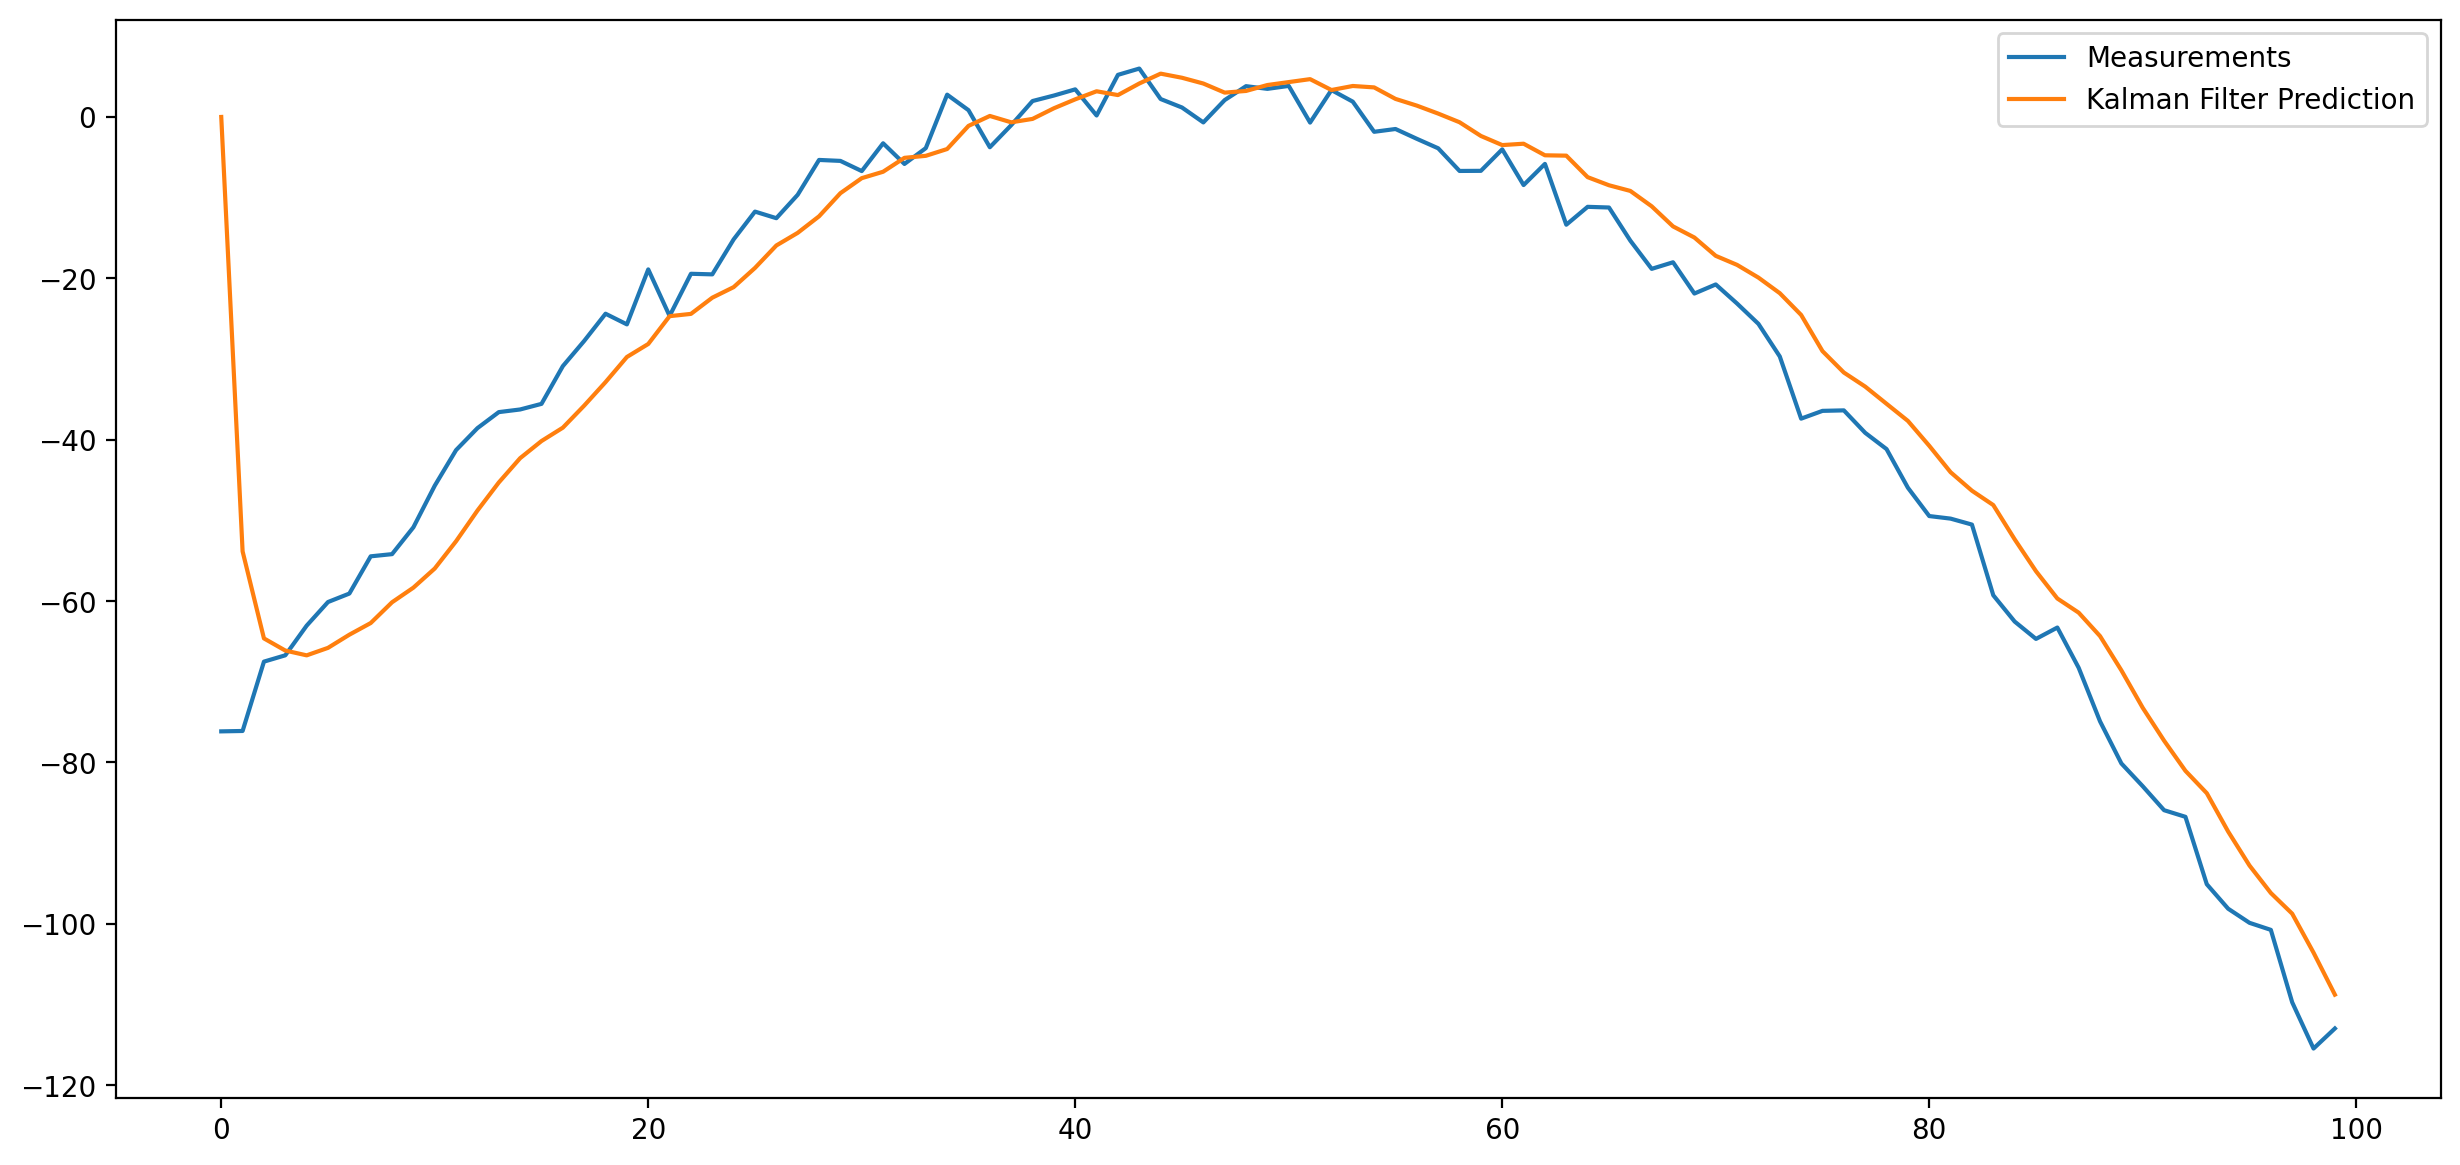

In [827]:
import numpy as np

class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = self.F @ self.x + np.dot(self.B, u)
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, z):
        y = z - self.H @ self.x
        S = self.R + self.H @ self.P @ self.H.T # update state
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(self.n)
        self.P = (I - K @ self.H) @ self.P @ (I - K @ self.H).T + (K @self.R @ K.T)


dt = 1.0/60
F = np.array([
    [1, dt, 0],
    [0, 1, dt],
    [0, 0, 1]
])
H = np.array([1, .3, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

x = np.linspace(-10, 10, 100)
measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)
measurements = measurements.reshape(-1,1)
kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []

for z in measurements:
    predictions.append(np.dot(H,  kf.predict())[0])
    kf.update(z)

import matplotlib.pyplot as plt
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()




In [900]:
import numpy as np

class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0 # hidden state (latent variable)

    def predict(self, u = 0):
        print(self.x)
        #self.x = self.F @ self.x + np.dot(self.B, u)
        #self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, z):
        # z = observation, x = latent state
        y = z - self.x @ self.H.T  # back to multivar space
        S = self.R + self.H @ self.P @ self.H.T # update state
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(self.n)
        self.P = (I - K @ self.H) @ self.P @ (I - K @ self.H).T + (K @self.R @ K.T)


dt = 1.0/60
F = np.array([
    [1, dt, 0],
    [0, 1, dt],
    [0, 0, 1]
])
F = np.array([[1],[dt],[0]])
H = np.array([1, .3, 0]).reshape(3, 1)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

x = np.linspace(-10, 10, 100)
measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)
measurements = measurements.reshape(-1,1)
measurements = measurements @ H.T
kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []

for z in measurements:
    predictions.append(np.dot(H,  kf.predict())[0])
    kf.update(z)

import matplotlib.pyplot as plt
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()




[[0.]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 3)

In [899]:
measurements

array([[-7.63539805e+01, -2.29061942e+01,  0.00000000e+00],
       [-7.40044455e+01, -2.22013336e+01,  0.00000000e+00],
       [-7.00610651e+01, -2.10183195e+01,  0.00000000e+00],
       [-6.89937782e+01, -2.06981335e+01,  0.00000000e+00],
       [-6.50480724e+01, -1.95144217e+01,  0.00000000e+00],
       [-6.12824474e+01, -1.83847342e+01,  0.00000000e+00],
       [-5.66255580e+01, -1.69876674e+01,  0.00000000e+00],
       [-5.35163031e+01, -1.60548909e+01,  0.00000000e+00],
       [-4.83299073e+01, -1.44989722e+01,  0.00000000e+00],
       [-4.83160098e+01, -1.44948029e+01,  0.00000000e+00],
       [-4.50965179e+01, -1.35289554e+01,  0.00000000e+00],
       [-4.38129476e+01, -1.31438843e+01,  0.00000000e+00],
       [-4.03146821e+01, -1.20944046e+01,  0.00000000e+00],
       [-3.64756463e+01, -1.09426939e+01,  0.00000000e+00],
       [-3.62695853e+01, -1.08808756e+01,  0.00000000e+00],
       [-3.25029703e+01, -9.75089110e+00,  0.00000000e+00],
       [-3.28700468e+01, -9.86101403e+00

In [885]:
kf.H @ np.array([[1]])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 3)

In [883]:
kf.x

array([[-49.84088326, -14.95226498,   0.        ],
       [ -3.80793664,  -1.14238099,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

Final Estimated States:
[-0.00192273  0.0452165   0.08560414]


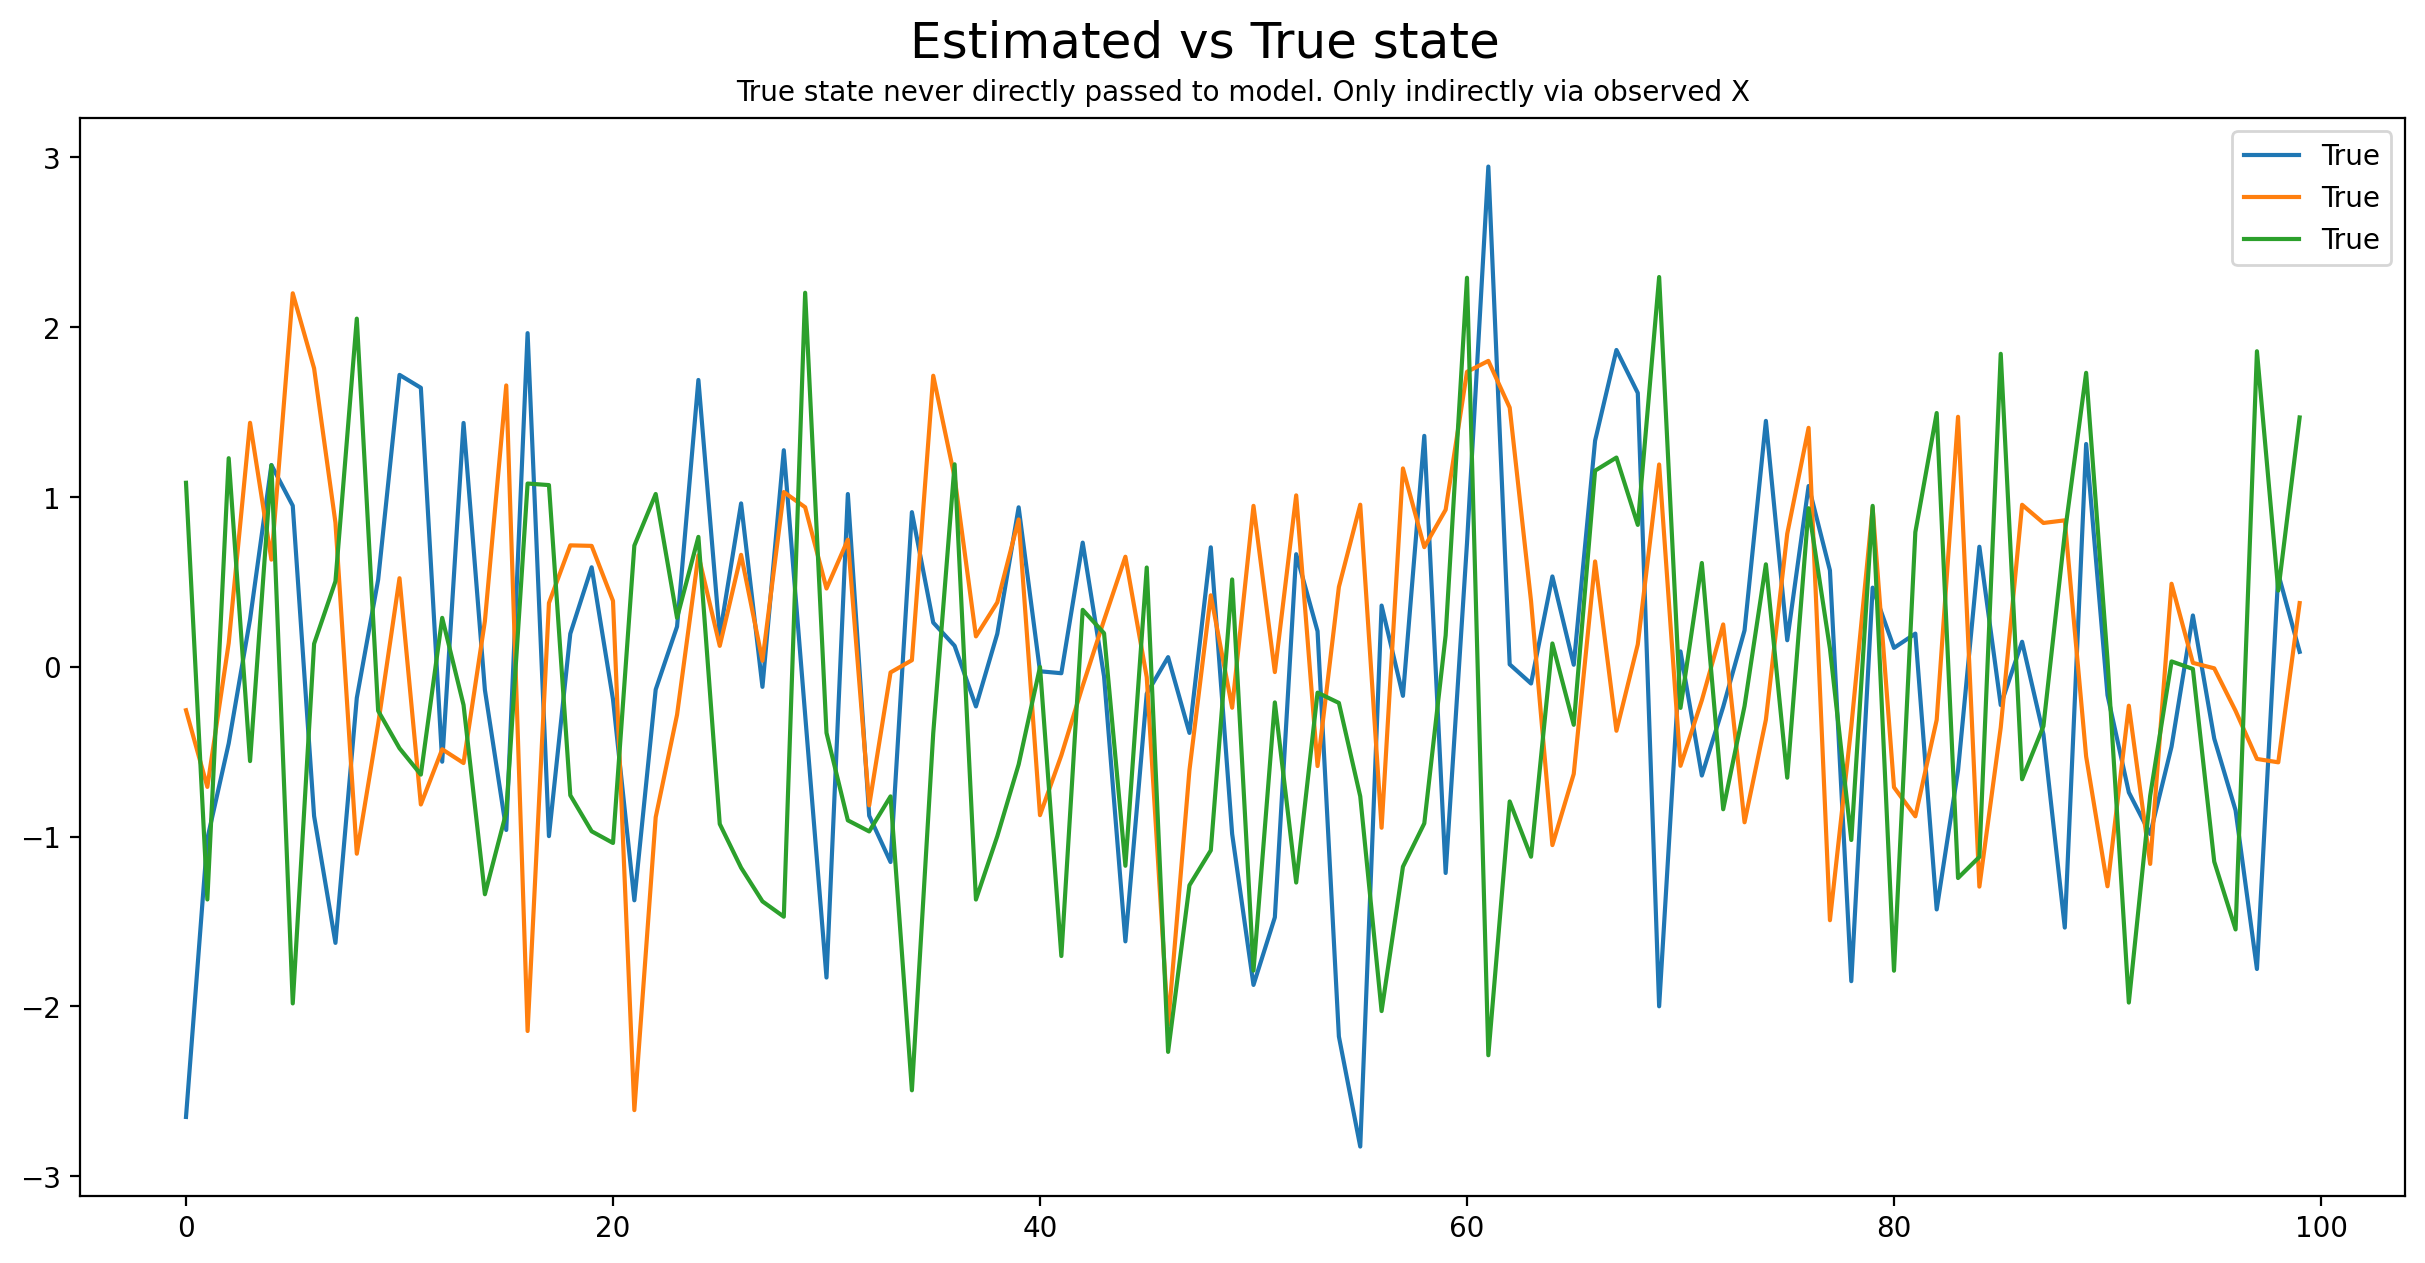

In [920]:
import numpy as np

def kalman_filter(X, A, H, Q, R, initial_state, initial_covariance):
    """
    Kalman filter implementation for estimating a single latent state.

    Parameters:
    - X: Input matrix of observations (shape: (3, T))
    - A: State transition matrix (shape: (3, 3))
    - H: Observation matrix (shape: (3, 3))
    - Q: Process noise covariance matrix (shape: (3, 3))
    - R: Observation noise covariance matrix (shape: (3, 3))
    - initial_state: Initial state estimate (shape: (3, 1))
    - initial_covariance: Initial state covariance matrix (shape: (3, 3))

    Returns:
    - state_estimates: Array of estimated latent states (shape: (3, T))
    - state_covariances: Array of state covariance matrices (shape: (3, 3, T))
    """

    T = X.shape[1]

    state_estimates = np.zeros((3, T))
    state_covariances = np.zeros((3, 3, T))

    # Initialization
    state_estimate = initial_state
    state_covariance = initial_covariance

    for t in range(T):
        # Prediction Step
        state_estimate_pred = A @ state_estimate
        state_covariance_pred = A @ state_covariance @ A.T + Q

        # Update Step
        observation_residual = X[:, t].reshape(-1, 1) - H @ state_estimate_pred
        observation_covariance = H @ state_covariance_pred @ H.T + R
        kalman_gain = state_covariance_pred @ H.T @ np.linalg.inv(observation_covariance)
        state_estimate = state_estimate_pred + kalman_gain @ observation_residual
        state_covariance = (np.eye(3) - kalman_gain @ H) @ state_covariance_pred

        # Save results
        state_estimates[:, t] = state_estimate.flatten()
        state_covariances[:, :, t] = state_covariance

    return state_estimates, state_covariances

# Example Usage
T = 100  # Number of time points
latent_state = np.random.randn(3, T)  # Example latent state
noise = np.random.randn(3, T) * 0.1  # Observation noise
X = latent_state + noise  # Example input matrix

# Define Kalman filter parameters
A = np.array([[0.5, 0.2, 0.1],
              [1, 0, 0],
              [0, 1, 0]])  # State transition matrix for AR(3) model
H = np.eye(3)  # Observation matrix (identity matrix since all measurements are of the latent state)
Q = np.eye(3) * 0.01  # Process noise covariance
R = np.eye(3) * 0.1  # Observation noise covariance
initial_state = np.zeros((3, 1))  # Initial state estimate
initial_covariance = np.eye(3)  # Initial state covariance

# Run Kalman filter
state_estimates, state_covariances = kalman_filter(X, A, H, Q, R, initial_state, initial_covariance)

# Print the final estimated states
print("Final Estimated States:")
print(state_estimates[:, -1])

# Print the final estimated state
plt.plot(latent_state.T, label="True");
#plt.plot(state_estimates, label="Estimated");
plt.suptitle("Estimated vs True state", y=.95, fontsize=18)
plt.title("True state never directly passed to model. Only indirectly via observed X", fontsize=10)
plt.legend();

In [918]:
latent_state.T

array([[ 8.04825294e-01,  4.00968130e-03,  4.42230496e-01],
       [ 1.18897419e+00, -6.33091791e-01, -2.86139535e-01],
       [ 8.48189368e-01, -2.30200721e+00, -2.88147855e-01],
       [-7.27926492e-02,  6.93085710e-01, -8.02796609e-01],
       [-1.66825409e+00,  1.09093707e+00, -9.68730214e-02],
       [ 8.67235748e-01, -1.63195410e+00, -7.71339374e-01],
       [-8.05337874e-01,  1.74630380e+00, -8.62371665e-02],
       [-4.45308284e-01,  4.27157513e-01, -8.55629457e-01],
       [ 3.26285747e-01, -1.41785305e+00, -8.02093689e-01],
       [-1.82012477e+00, -6.05909965e-01,  5.91690712e-01],
       [ 1.77238187e-01,  1.04756315e+00,  1.51895846e+00],
       [-4.51247096e-01,  8.44857388e-01,  1.57087432e+00],
       [-1.14106836e+00,  1.56027270e+00, -1.01388958e+00],
       [ 1.55388319e-01,  1.76449114e+00,  3.00190569e-01],
       [-1.10455000e+00, -5.17392060e-01, -9.18277167e-01],
       [ 1.82971030e-01, -9.64223519e-02, -6.05437589e-01],
       [ 3.41822115e-01,  6.17302846e-01

In [1018]:
import numpy as np

class KalmanFilter:
    def __init__(self, A, B, H, Q, R, mu0, P0):
        self.A = A  # State transition matrix
        self.B = B  # Control matrix (not used in this case)
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.mu = mu0  # Initial state estimate
        self.P = P0  # Initial covariance estimate

    def predict(self):
        # Predict the next state
        self.mu = np.dot(self.A, self.mu)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q

    def update(self, z):
        # Update the state estimate based on measurement z
        y = z - np.dot(self.H, self.mu)
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.mu = self.mu + np.dot(K, y)
        self.P = self.P - np.dot(np.dot(K, self.H), self.P)

# Parameters
A = np.array([[0.7]])  # State transition matrix (ARIMA(2,3) coefficient)
H = np.array([[0.5], [0.3], [0.2]])  # Observation matrix (factor loadings)
Q = np.array([[0.01]])  # Process noise covariance
R = np.eye(3) * 0.1  # Measurement noise covariance
mu0 = np.array([[0]])  # Initial state estimate
P0 = np.eye(1) * 0.1  # Initial covariance estimate

# Initialize Kalman Filter
kf = KalmanFilter(A=A, B=None, H=H, Q=Q, R=R, mu0=mu0, P0=P0)
simulated_state = simulate_ar3(100, [0.8])
# Simulated observations (responses to the questions)
z = np.array([[1], [2], [3]])

# Perform prediction and update
kf.predict()
kf.update(z)

# Get the predicted latent state for the next time step
predicted_state = np.dot(H, kf.mu)
print("Predicted intent to drop out of school:", predicted_state[0, 0])


Predicted intent to drop out of school: 0.40965528508413657


In [922]:
kf.mu

array([[0.81931057]])

In [947]:
int_DO = np.cumsum(np.random.normal(1,10,100))

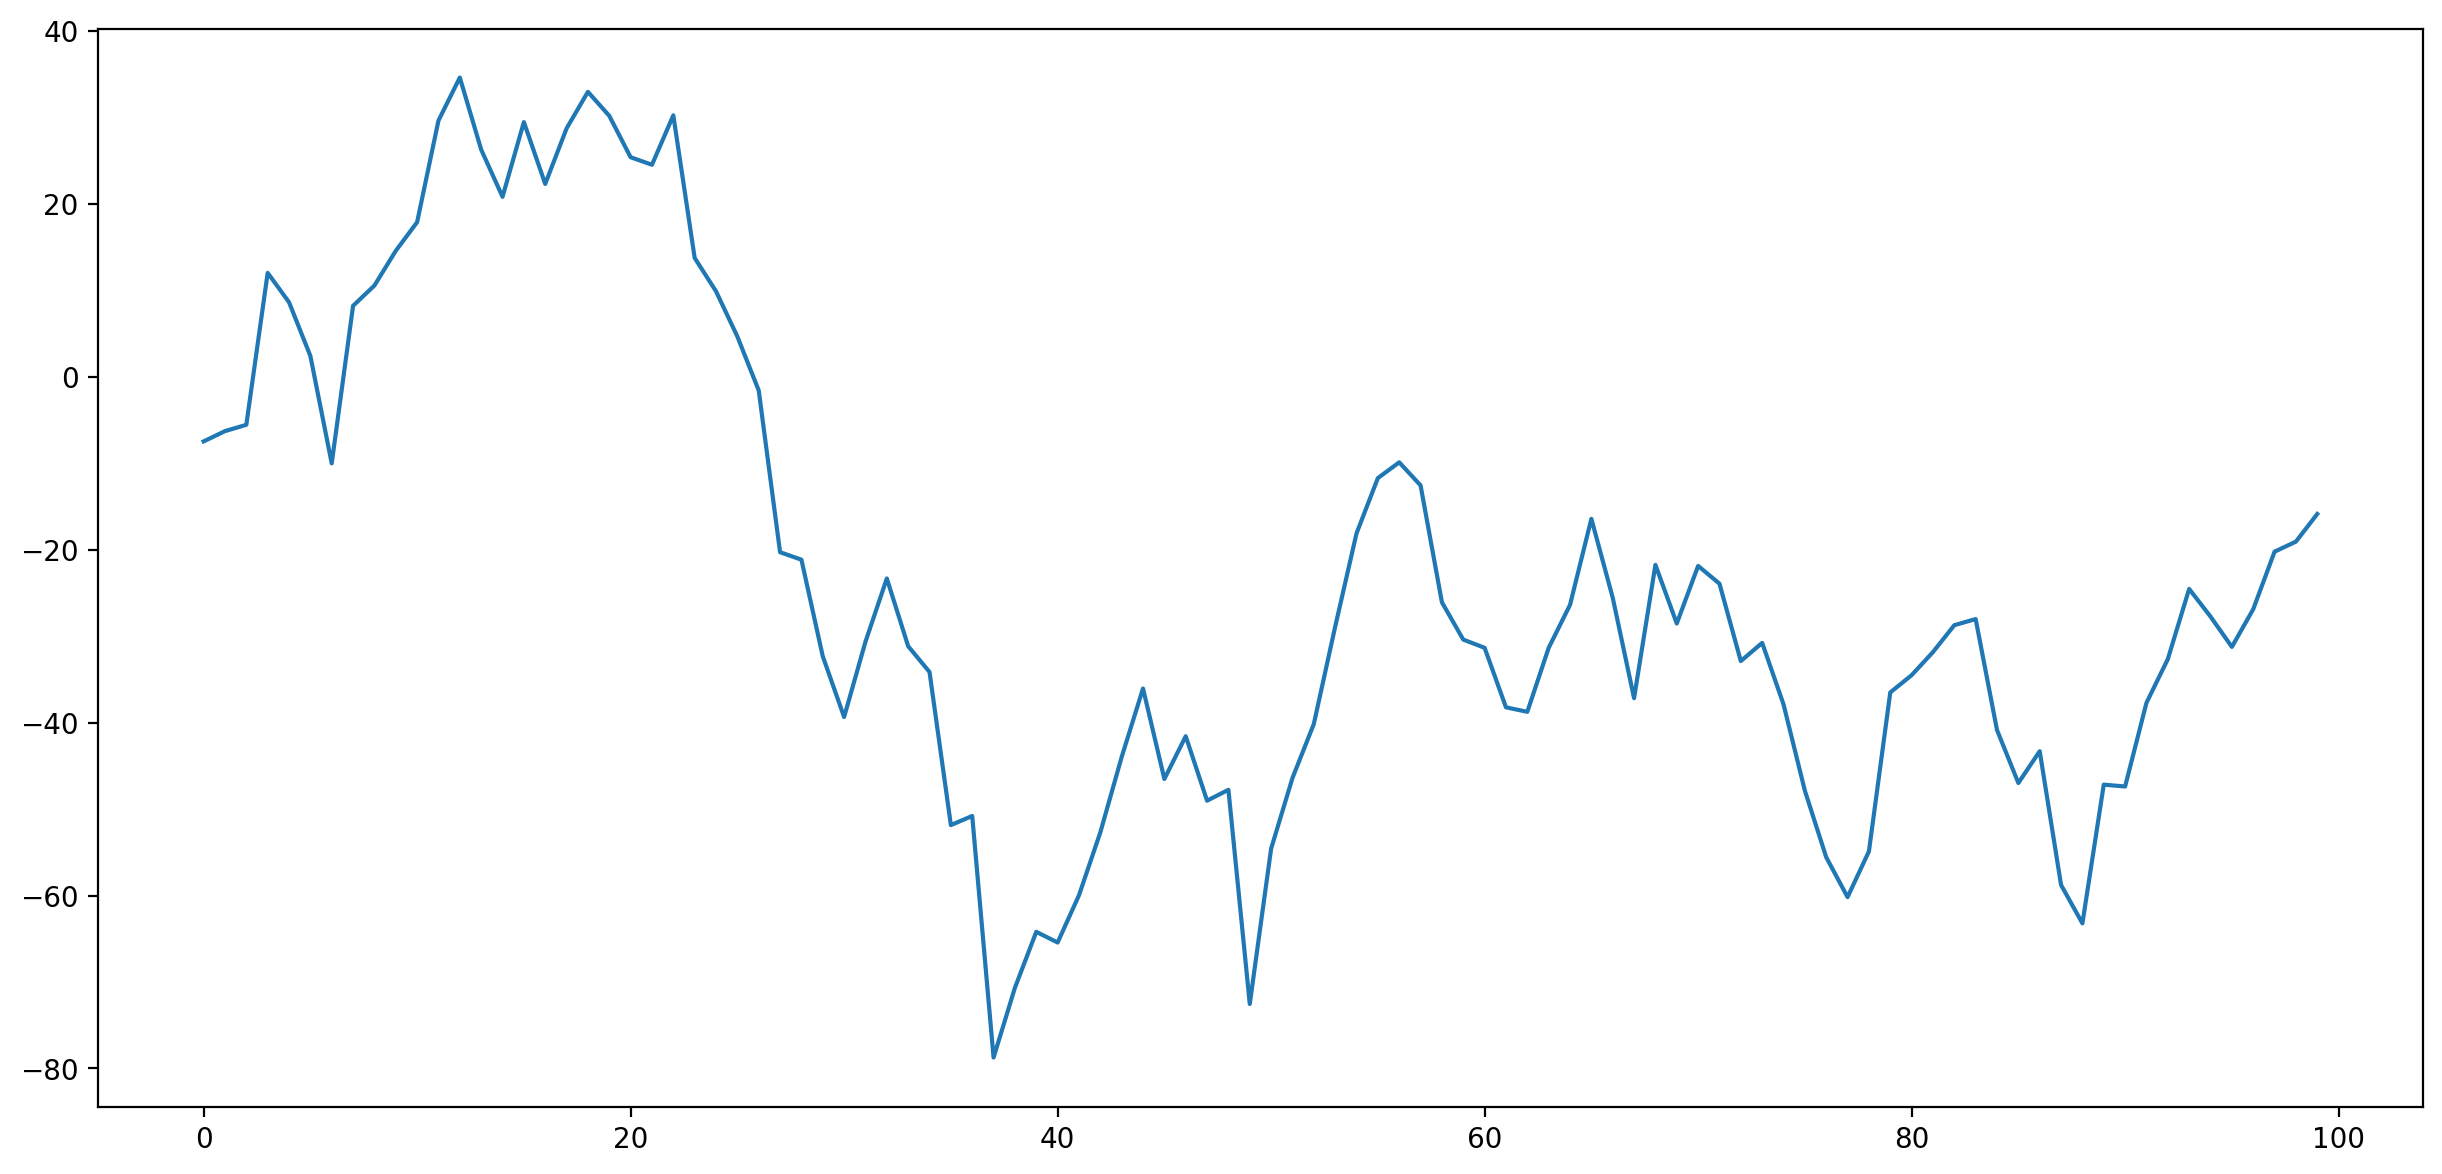

In [948]:
plt.plot(int_DO)

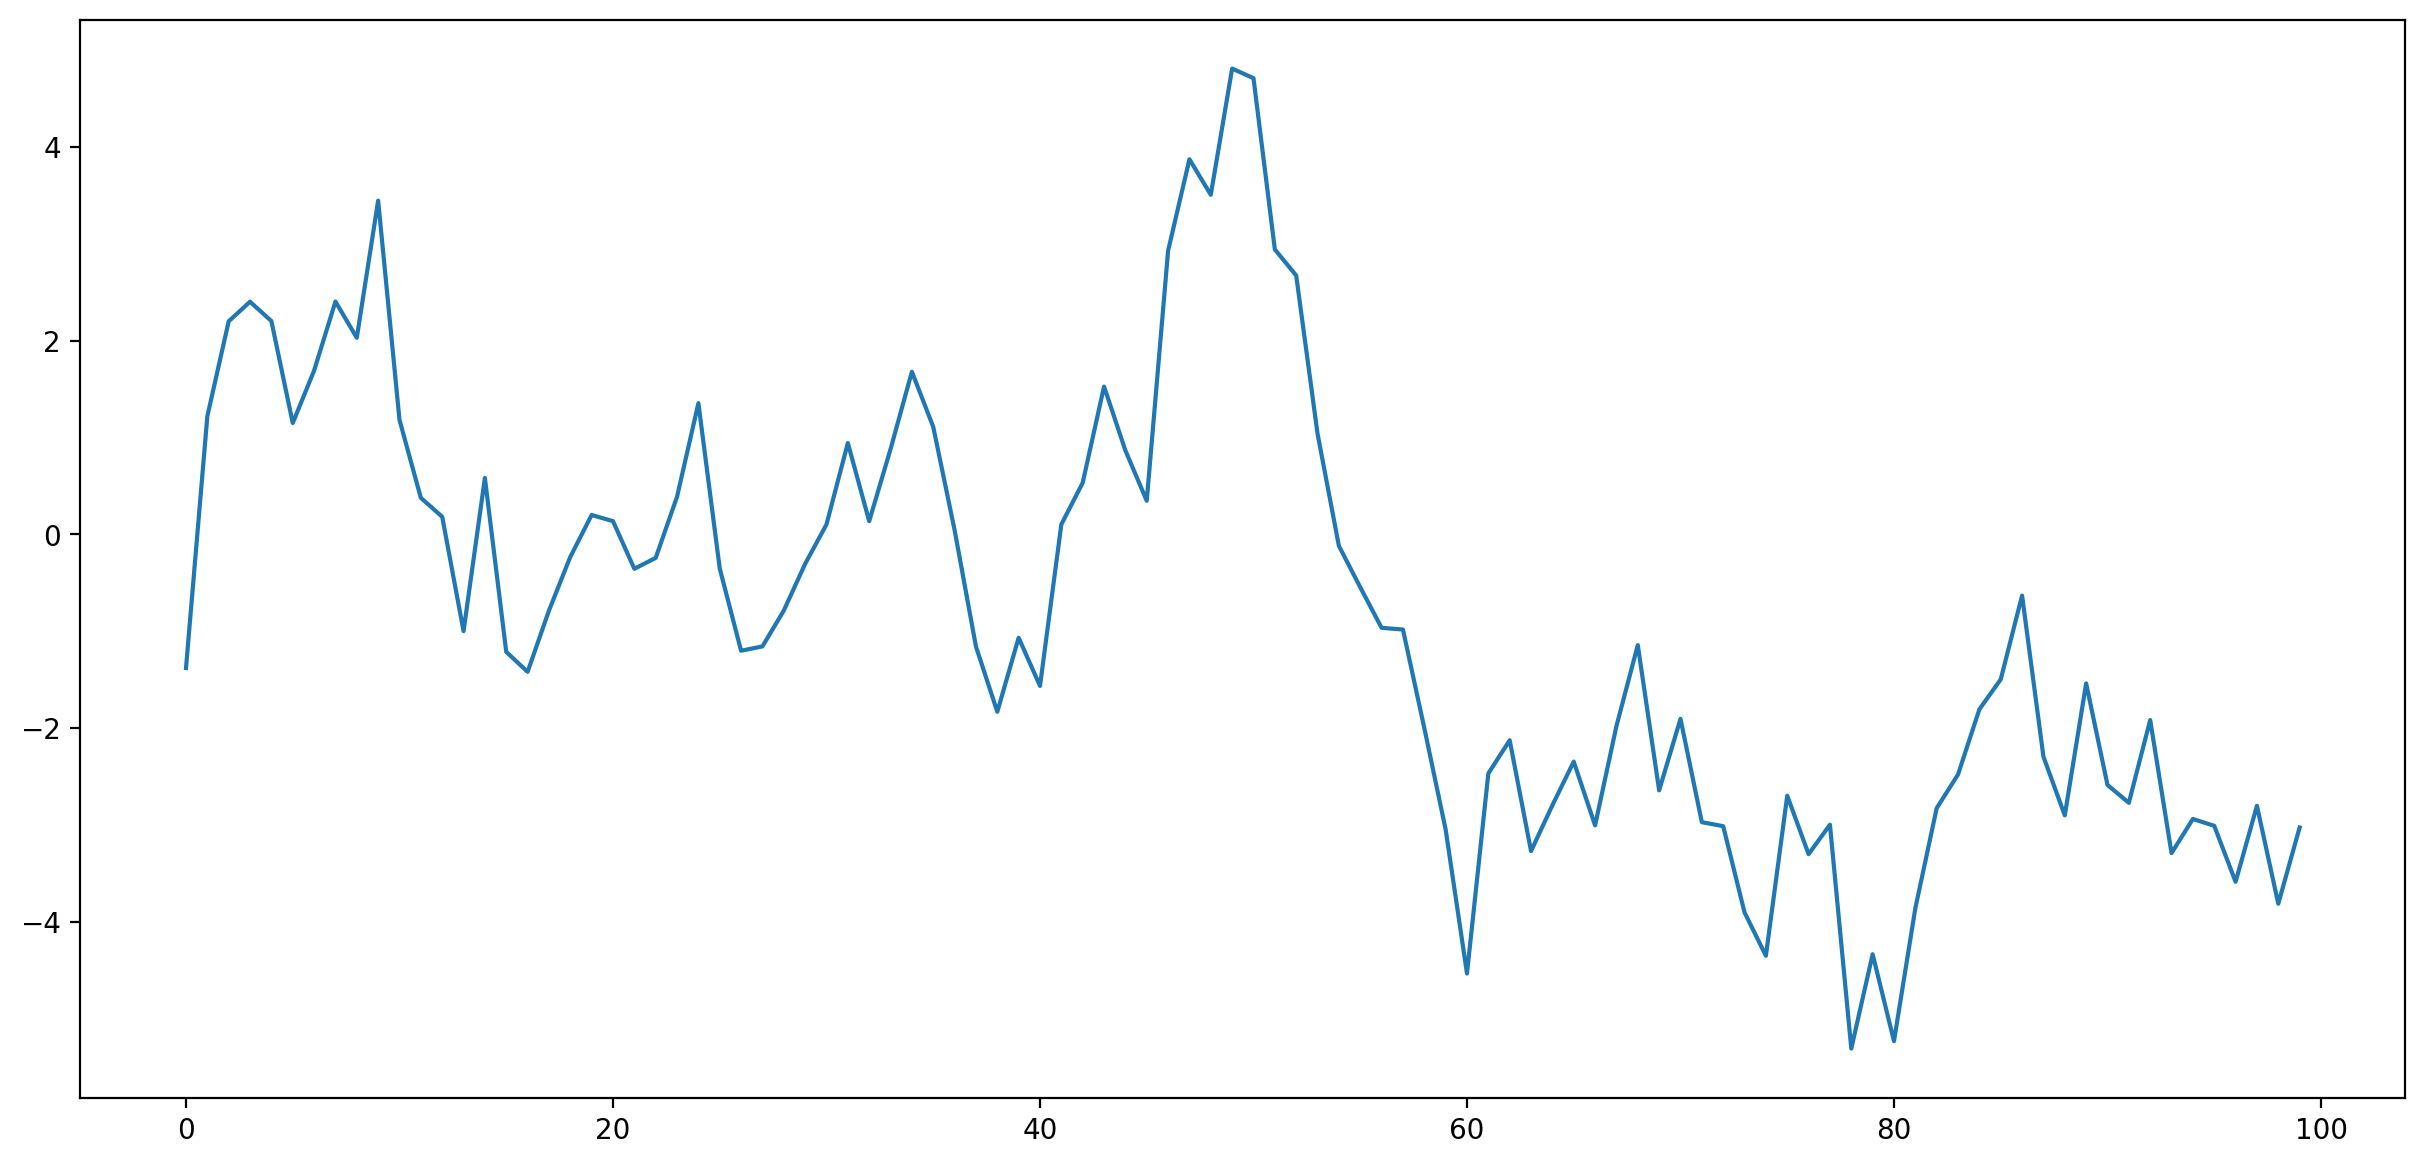

In [1017]:
import numpy as np

def simulate_ar3(n_samples, phi):
    """
    Simulate AR(3) data.

    Parameters:
    - n_samples: int, number of samples to generate
    - phi: array-like, AR parameters [phi1, phi2, phi3]

    Returns:
    - simulated_data: array-like, simulated data
    """
    p = len(phi)
    simulated_data = np.zeros(n_samples + p)  # Leave room for initial values
    # Initialize with random noise
    simulated_data[:p] = np.random.randn(p)
    # Generate data based on AR(3) process
    for t in range(p, n_samples + p):
        simulated_data[t] = np.dot(phi, simulated_data[t - p:t][::-1]) + np.random.randn()
    return simulated_data[p:]

# Parameters
n_samples = 100  # Number of samples to generate
phi = np.array([0.8, 0.1, 0])  # AR parameters

# Simulate AR(3) data
simulated_data = simulate_ar3(n_samples, phi)

plt.plot( simulated_data)


In [1016]:
import numpy as np
import statsmodels.api as sm

# Simulated AR(3) data
n_samples = 10000
phi_true = np.array([0.87, .1, 0])
simulated_data = simulate_ar3(n_samples, phi_true)

# Create lagged matrix
X = np.column_stack([simulated_data[i:-3+i] for i in range(3)])
y = simulated_data[3:]

# Add a constant term if needed
# X = sm.add_constant(X)

# Fit AR(3) model
model = sm.OLS(y, X)
results = model.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                          4.764e+04
Date:                Wed, 07 Feb 2024   Prob (F-statistic):                        0.00
Time:                        15:21:54   Log-Likelihood:                         -14177.
No. Observations:                9997   AIC:                                  2.836e+04
Df Residuals:                    9994   BIC:                                  2.838e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0181      0.010      1.813      0.070      -0.001       0.038
x2             0.0810      0.013      6.114      0.000       0.055       0.107
x3             0.8712      0.010     87.106      0.000       0.852       0.891
==============================================================================
Omnibus:                        0.998   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                1.029
Skew:                          -0.019   Prob(JB):                        0.598
Kurtosis:                       2.968   Cond. No.                         10.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1004]:
simulated_data

array([-1.76372791, -2.74379883, -3.12172593, ...,  3.33543944,
        3.78861222,  2.72848412])

In [1015]:
# Create lagged matrix
np.column_stack([simulated_data[i:-3+i] for i in range(3)])


array([[-1.76372791, -2.74379883, -3.12172593],
       [-2.74379883, -3.12172593, -3.34753641],
       [-3.12172593, -3.34753641, -3.55284869],
       ...,
       [ 2.76979086,  3.9966804 ,  3.32919196],
       [ 3.9966804 ,  3.32919196,  3.33543944],
       [ 3.32919196,  3.33543944,  3.78861222]])

In [1011]:
range(3)

range(0, 3)

In [ ]:
def kalman_smoother(state_estimates, state_covariances, A):
    """
    Kalman smoother implementation for refining state estimates.

    Parameters:
    - state_estimates: Array of estimated latent states (shape: (1, T))
    - state_covariances: Array of state covariance matrices (shape: (1, 1, T))
    - A: State transition matrix (shape: (1, 1))

    Returns:
    - smoothed_state_estimates: Array of smoothed latent states (shape: (1, T))
    """

    T = state_estimates.shape[1]

    smoothed_state_estimates = np.zeros((1, T))

    # Initialization
    smoothed_state_estimates[:, -1] = state_estimates[:, -1]

    for t in range(T-2, -1, -1):
        # Smoothing step
        smoothed_state_estimates[:, t] = state_estimates[:, t] + \
                                         state_covariances[:, :, t] @ A.T @ \
                                         np.linalg.inv(state_covariances[:, :, t+1]) @ \
                                         (smoothed_state_estimates[:, t+1] - A @ state_estimates[:, t+1])

    return smoothed_state_estimates
